## Bijdragende lengte

Bij bepalingen van de systeemveiligheid is de bijdragende lengte voor verschillende mechanismen een belangrijke parameter. In dit notebook laten we zien hoe dit kan worden bepaald voor een dijktraject uit een veiligheidsrendementanalyse.

In [1]:
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import numpy as np
from scipy.stats import norm
from peewee import fn

from vrtool.orm.models import *
from vrtool.orm.orm_controllers import open_database
from vrtool.common.enums import MechanismEnum
from postprocessing.database_analytics import *
from postprocessing.database_access_functions import * 

from postprocessing.generate_output import *
import matplotlib.pyplot as plt
from common_functions.Deltares_colors import Deltares_colors

sns.set(style="whitegrid")
colors =  Deltares_colors().sns_palette("DeltaresFull")


In [2]:
# db_path = Path(r"c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\47-1\database_47-1_aangepast_20240816.db")
# db_path = Path(r"c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\10-1\versie 2\10-1_Trajectaanpak_metbodemdaling\database_10-1.sqlite")
db_path = Path(r"c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\38-1\lengte_effecten\38-1_basis.db")
# db_path = Path(r"c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\10-1\versie 1\lengte-effecten\database_10-1.sqlite")
has_revetment = False

_runs_overview = get_overview_of_runs(db_path)
print(_runs_overview)


[{'id': 1, 'name': 'Basisberekening Veiligheidsrendement', 'discount_rate': 0.016, 'optimization_type': 1, 'optimization_type_name': 'VEILIGHEIDSRENDEMENT'}, {'id': 2, 'name': 'Basisberekening Doorsnede-eisen', 'discount_rate': 0.016, 'optimization_type': 2, 'optimization_type_name': 'DOORSNEDE-EISEN'}]


Get the base data from the database

In [3]:
traject_length = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_length
p_max = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).p_max
a_piping = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).a_piping

# optimization_steps = get_optimization_steps_for_run_id(db_path, 1)
optimization_steps = get_optimization_steps_for_run_id(db_path, 2)
considered_tc_step = get_minimal_tc_step(optimization_steps)-1

lists_of_measures = get_measures_for_run_id(db_path, 1)
measures_per_step = get_measures_per_step_number(lists_of_measures)

assessment_results = {}
for mechanism in [MechanismEnum.OVERFLOW, MechanismEnum.PIPING, MechanismEnum.STABILITY_INNER, MechanismEnum.REVETMENT]:
    if has_revetment or mechanism != MechanismEnum.REVETMENT:
        assessment_results[mechanism] = import_original_assessment(db_path, mechanism)


reliability_per_step = get_reliability_for_each_step(db_path, measures_per_step)

stepwise_assessment = assessment_for_each_step(copy.deepcopy(assessment_results), reliability_per_step)

traject_probability = calculate_traject_probability_for_steps(stepwise_assessment)

def calculate_traject_probability(traject_prob):
    p_nonf = [1] * len(list(traject_prob.values())[0].values())
    for mechanism, data in traject_prob.items():
        time, pf = zip(*sorted(data.items()))
        p_nonf = np.multiply(p_nonf, np.subtract(1,pf))
    return time, list(1-p_nonf)

traject_probs = [calculate_traject_probability(traject_probability_step ) for traject_probability_step in traject_probability]

#get the section lengths from the database
section_lengths = pd.DataFrame([(section.id, section.section_length) for section in SectionData.select()],columns= ['section_id', 'section_length'])
section_lengths.set_index('section_id', inplace=True)

First we get the length that contributes for piping and stbi in the original situation.

In [4]:
def derive_contributing_length_for_step(assessment_result, section_lengths, a_vak_stbi=1.0):
    #get the betas for stbi in step 0 from stepwise assessment
    betas_stbi ={section_id: section['beta'][0] for section_id, section in assessment_result[MechanismEnum.STABILITY_INNER].items()}
    betas_piping ={section_id: section['beta'][0] for section_id, section in assessment_result[MechanismEnum.PIPING].items()}
    beta_df = pd.concat((section_lengths, pd.DataFrame.from_dict(betas_stbi,orient='index'), pd.DataFrame.from_dict(betas_piping,orient='index')), axis=1)
    beta_df.columns = ['section_length', 'beta_STBI_dsn', 'beta_STPH_dsn']
    #convert beta to pf
    beta_df['pf_STBI_dsn'] = beta_to_pf(beta_df['beta_STBI_dsn'])
    beta_df['pf_STPH_dsn'] = beta_to_pf(beta_df['beta_STPH_dsn'])

    beta_df.head()

    #N_of_sections
    beta_df['N_STBI'] = a_vak_stbi* beta_df['section_length']/ 50
    beta_df['N_STPH'] = beta_df['section_length']/ 300
    #N should be at least 1
    beta_df['N_STBI'] = beta_df['N_STBI'].apply(lambda x: max(1,x))
    beta_df['N_STPH'] = beta_df['N_STPH'].apply(lambda x: max(1,x))
    return beta_df

def plot_contributing_length_for_STBI(df):
    #sort for STBI
    df.sort_values(by='pf_STBI_dsn', ascending=False, inplace=True)
    df['L_STBI_cum'] = df['N_STBI'].cumsum() * 50
    df['a_STBI'] = df['L_STBI_cum'] / traject_length
    #make a plot of length vs pf
    fig, ax = plt.subplots()
    ax.plot(df['a_STBI'], df['pf_STBI_dsn'], label='STBI')
    ax.set_ylabel('Pf/Pf_max_dsn')
    ax.set_yscale('log')
    # ax.set_ylim(1, 1000000)
    ax.set_xlim(0, max(df['a_STBI']))

    ax.vlines(0.033, 1, 1e6, color='r', label='0.033')
    ax.legend()

def plot_contributing_length_for_STPH(df):
    #sort for STPH
    df.sort_values(by='pf_STPH_dsn', ascending=False, inplace=True)
    df['L_STPH_cum'] = df['N_STPH'].cumsum() * 300
    df['a_STPH'] = df['L_STPH_cum'] / traject_length
    #make a plot of length vs pf
    fig, ax = plt.subplots()
    ax.plot(df['a_STPH'], df['pf_STPH_dsn'], label='STPH')
    ax.set_yscale('log')
    # ax.set_ylim(1, 1000000)
    ax.set_xlim(0, max(df['a_STPH']))
    ax.set_ylabel('Pf/Pf_max_dsn')
    ax.vlines(0.4, 1, 1e6, color='r', label='a = 0.4')
    ax.vlines(0.9, 1, 1e6, color='r', label='a = 0.9')
    ax.legend()

def compute_cumulative_probability_for_sections(df):
    #compute the cumulative failure probability relative to the length for piping
    df['pf_STBI_vak'] = 1-(1-df['pf_STBI_dsn']) ** df['N_STBI']
    df['pf_STPH_vak'] = 1-(1-df['pf_STPH_dsn']) ** df['N_STPH']
    #sort for STBI
    df.sort_values(by='pf_STBI_vak', ascending=False, inplace=True)
    df['L_STBI_cum'] = df['N_STBI'].cumsum() * 50

    #combine the sections as independent by taking 1-(1-pf of previous sections)
    df['pf_STBI_vak_cum'] = 1 - np.cumprod(1-df['pf_STBI_vak'])

    #do the same for STPH
    df.sort_values(by='pf_STPH_vak', ascending=False, inplace=True)
    df['L_STPH_cum'] = df['N_STPH'].cumsum() * 300
    df['pf_STPH_vak_cum'] = 1 - np.cumprod(1-df['pf_STPH_vak'])
    return df

def plot_cumulative_probability_for_sections(df, normalized = False):
    fig, ax = plt.subplots(ncols=2,figsize=(8,4))
    if not normalized:
        df.sort_values(by='L_STBI_cum', inplace=True)
        ax[0].plot(df['L_STBI_cum'], df['pf_STBI_vak_cum'], label='STBI')
        ax[0].set_yscale('log')
        ax[0].set_ylim(bottom = 10 ** np.floor(np.log10(df['pf_STBI_vak_cum'].min())),
                       top=  10 ** np.ceil(np.log10(df['pf_STBI_vak_cum'].max())))
        ax[0].set_xlim(0, max(df['L_STPH_cum']))
        ax[0].set_ylabel('Pf_cum')
        
        df.sort_values(by='L_STPH_cum', inplace=True)
        ax[1].plot(df['L_STPH_cum'], df['pf_STPH_vak_cum'], label='STPH')
        ax[1].set_yscale('log')
        ax[1].set_ylim(top= 10 ** np.ceil(np.log10(df['pf_STPH_vak_cum'].max())), 
                       bottom = 10 ** np.floor(np.log10(df['pf_STPH_vak_cum'].min())))
        ax[1].set_xlim(0, max(df['L_STPH_cum']))
        ax[1].set_ylabel('Pf_cum')
    else:
        #same but normalize with the maximum pf for dsn for both
        df.sort_values(by='L_STBI_cum', inplace=True)
        ax[0].plot(df['L_STBI_cum'], df['pf_STBI_vak_cum']/max(df['pf_STBI_vak_cum']), label='STBI')
        ax[0].set_ylabel('Pf_cum_vak/Pf_cum_max')
        df.sort_values(by='L_STPH_cum', inplace=True)
        ax[1].plot(df['L_STPH_cum'], df['pf_STPH_vak_cum']/max(df['pf_STPH_vak_cum']), label='STPH')
        ax[1].set_ylabel('Pf_cum_vak/Pf_cum_max')
    
    ax[0].set_xlabel('L [m]')
    ax[1].set_xlabel('L [m]')
    ax[0].legend()
    ax[1].legend()






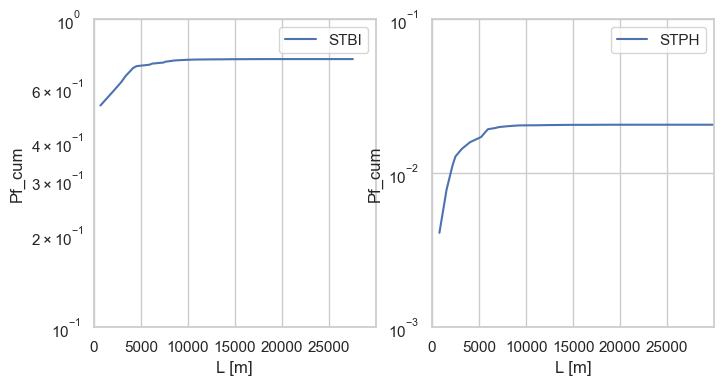

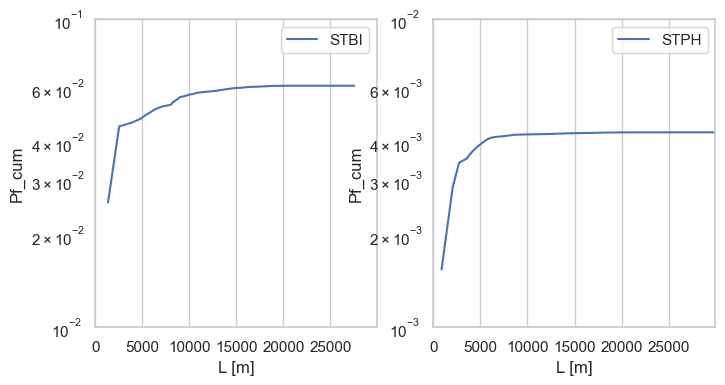

In [5]:
a_vak_stbi = 1.0
original_assessment_contributing_length = derive_contributing_length_for_step(stepwise_assessment[0], section_lengths, a_vak_stbi=a_vak_stbi)
# plot_contributing_length_for_STBI(original_assessment_contributing_length)
# plot_contributing_length_for_STPH(original_assessment_contributing_length)
original_assessment_contributing_length = compute_cumulative_probability_for_sections(original_assessment_contributing_length)
plot_cumulative_probability_for_sections(original_assessment_contributing_length, normalized=False)

reinforced_contributing_length = derive_contributing_length_for_step(stepwise_assessment[considered_tc_step], section_lengths, a_vak_stbi=a_vak_stbi)
# plot_contributing_length_for_STBI(reinforced_contributing_length)
# plot_contributing_length_for_STPH(reinforced_contributing_length)

reinforced_contributing_length = compute_cumulative_probability_for_sections(reinforced_contributing_length)
plot_cumulative_probability_for_sections(reinforced_contributing_length, normalized=False)


(0.0, 1.1)

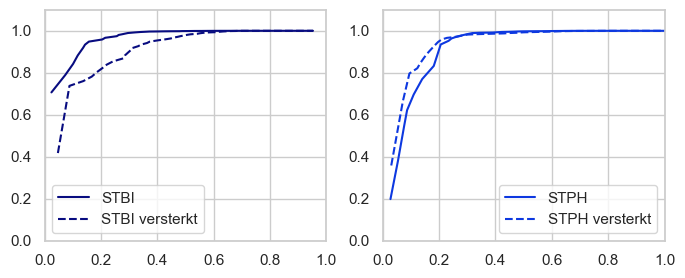

In [6]:
#make a comparison of both per mechanism in 2 panes
fig, ax = plt.subplots(1,2, figsize=(8,3))
#sort both on STBI
original_assessment_contributing_length.sort_values(by='L_STBI_cum', inplace=True)
reinforced_contributing_length.sort_values(by='L_STBI_cum', inplace=True)
ax[0].plot(original_assessment_contributing_length['L_STBI_cum']/traject_length, original_assessment_contributing_length['pf_STBI_vak_cum']/max(original_assessment_contributing_length['pf_STBI_vak_cum']), label='STBI', color = colors[0])
ax[0].plot(reinforced_contributing_length['L_STBI_cum']/traject_length, reinforced_contributing_length['pf_STBI_vak_cum']/max(reinforced_contributing_length['pf_STBI_vak_cum']), label='STBI versterkt', color = colors[0], linestyle='--')

ax[0].legend()
ax[0].set_xlim(0,1)
ax[0].set_ylim(0,1.1)

original_assessment_contributing_length.sort_values(by='L_STPH_cum', inplace=True)
reinforced_contributing_length.sort_values(by='L_STPH_cum', inplace=True)
ax[1].plot(original_assessment_contributing_length['L_STPH_cum']/traject_length, original_assessment_contributing_length['pf_STPH_vak_cum']/max(original_assessment_contributing_length['pf_STPH_vak_cum']), label='STPH', color = colors[1])
ax[1].plot(reinforced_contributing_length['L_STPH_cum']/traject_length, reinforced_contributing_length['pf_STPH_vak_cum']/max(reinforced_contributing_length['pf_STPH_vak_cum']), label='STPH versterkt', color = colors[1], linestyle='--')
ax[1].legend()
ax[1].set_xlim(0,1)
ax[1].set_ylim(0,1.1)